<a href="https://colab.research.google.com/github/yuhui-0611/contest/blob/main/Poverty_Prediction_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

< Poverty Prediction Challenge >

- 주최: World Bank (세계은행) & DrivenData

- 목표: 제한된 설문(survey) 데이터를 활용하여 각각의 가구별 1인당 일일 소비량 (per-capita consumption)을 예측하고 이를 기반으로 인구 수준의 빈곤율 (poverty rate) 을 다양한 기준(threshold)으로 예측하는 모델 개발

< 실제 세계은행 연구자들이 직면하는 문제 >

✔ 오래된 설문조사에는 자세한 소비 데이터가 있지만

✔ 최근 설문에는 그 정보가 없을 때가 많음

- 이럴 경우 새로운 설문에서 소비량을 직접적으로 측정할 수 없기 때문에
- 머신러닝 모델을 활용해 이를 보간(imputation) 해야 함

> 즉: 과거 잘-레이블된 설문 → 새로운 설문 예측으로 소비량과 빈곤율 추정

< 데이터 구조 >

훈련(train) 데이터

- 여러 연도의 가구 설문 응답
- 각 가구의 1인당 일일 소비량(ground truth)
- 인구 가중치(weights)
- 설문 항목: 인구학, 교육, 주거, 식품 소비, 지리 등

테스트(test) 데이터

- 소비량/빈곤율 라벨 없음
- 기존 모델로 예측해야 함

성능 = 가구-레벨 소비 예측과 빈곤율 예측 오류 기반

< 주요 평가 지표 >
- 가중 평균 오차(metric)

> 빈곤율 예측 오차 → 약 90% 비중

> 가구 소비 예측 오차 → 약 10% 비중

즉, 빈곤율 예측 정확도가 사실상 승부를 가른다고 보면 됨

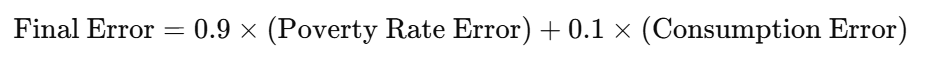

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DATA

X : Household survey features → 설명 변수

y₁ : Household consumption labels → 1인당 하루 소비액 (USD/day)

y₂ : Survey-level poverty rate labels → 설문 전체 빈곤율 (여러 빈곤선 threshold)

< 전체 순서 >

```
X + y1  → 가구 소비 모델 학습
예측된 소비 → 빈곤율 계산
계산된 빈곤율 ↔ y2 비교 (검증)
```



In [3]:
X = pd.read_csv('/content/drive/MyDrive/contest/train_hh_features.csv')
y1 = pd.read_csv('/content/drive/MyDrive/contest/train_hh_gt.csv')
y2 = pd.read_csv('/content/drive/MyDrive/contest/train_rates_gt.csv')

In [4]:
test = pd.read_csv('/content/drive/MyDrive/contest/test_hh_features.csv')

In [5]:
X.head()

,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4200,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,Yes,No,No,No,Yes,Yes,Yes,Yes,No,100000
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,Yes,No,No,No,No,Yes,Yes,No,No,100000
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,No,Yes,No,No,No,Yes,Yes,No,No,100000
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,Yes,No,No,Yes,No,Yes,Yes,Yes,No,100000


In [6]:
y1.head()

,survey_id,hhid,cons_ppp17
0,100000,100001,25.258402
1,100000,100002,16.996706
2,100000,100003,13.671848
3,100000,100004,7.189475
4,100000,100005,12.308855


In [7]:
y2.head()

,survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
0,100000,0.067364,0.118927,0.169905,0.221865,0.271564,0.319585,0.366329,0.419816,0.471454,0.523798,0.574413,0.623091,0.671263,0.721329,0.773303,0.819770,0.865121,0.909075,0.954239
1,200000,0.059326,0.111560,0.159023,0.211754,0.263100,0.311758,0.356914,0.407631,0.463443,0.512931,0.559361,0.609337,0.659291,0.708043,0.760932,0.809045,0.860350,0.906385,0.952805
2,300000,0.049803,0.100381,0.149502,0.200144,0.250192,0.300211,0.349596,0.399930,0.449845,0.499930,0.550082,0.599926,0.650088,0.699617,0.750341,0.800111,0.850081,0.899974,0.949988


In [8]:
test.head()

,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4200,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id
0,400001,1,320,4,567.80914,Female,4,0,1,0,...,No,No,No,No,No,Yes,Yes,Yes,No,400000
1,400002,1,480,4,561.70367,Female,6,0,1,1,...,Yes,No,No,No,No,Yes,Yes,Yes,No,400000
2,400003,1,320,4,183.16423,Male,4,0,0,0,...,Yes,No,Yes,No,Yes,Yes,No,Yes,No,400000
3,400004,1,320,4,696.02411,Male,4,0,0,1,...,Yes,Yes,No,No,No,Yes,Yes,No,No,400000
4,400005,1,320,4,286.95731,Male,4,0,0,1,...,Yes,No,No,No,No,No,Yes,No,No,400000


# Processing

< 전처리 순서 >


```
X, y1 merge
split
X / y 분리
결측치 처리 fit, transform
```



## X, y1 merge

In [9]:
train = X.merge(
    y1,
    on=["survey_id", "hhid"],
    how="inner",
    validate="one_to_one"
)

In [10]:
train.head()

,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id,cons_ppp17
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,No,No,No,Yes,Yes,Yes,Yes,No,100000,25.258402
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,No,No,No,No,Yes,Yes,No,No,100000,16.996706
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000,13.671848
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,Yes,No,No,No,Yes,Yes,No,No,100000,7.189475
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,No,No,Yes,No,Yes,Yes,Yes,No,100000,12.308855


In [11]:
train.columns

Index(['hhid', 'com', 'weight', 'strata', 'utl_exp_ppp17', 'male', 'hsize',
       'num_children5', 'num_children10', 'num_children18', 'age', 'owner',
       'water', 'toilet', 'sewer', 'elect', 'water_source',
       'sanitation_source', 'dweltyp', 'num_adult_female', 'num_adult_male',
       'num_elderly', 'employed', 'sworkershh', 'share_secondary', 'educ_max',
       'sfworkershh', 'any_nonagric', 'sector1d', 'region1', 'region2',
       'region3', 'region4', 'region5', 'region6', 'region7', 'urban',
       'consumed100', 'consumed200', 'consumed300', 'consumed400',
       'consumed500', 'consumed600', 'consumed700', 'consumed800',
       'consumed900', 'consumed1000', 'consumed1100', 'consumed1200',
       'consumed1300', 'consumed1400', 'consumed1500', 'consumed1600',
       'consumed1700', 'consumed1800', 'consumed1900', 'consumed2000',
       'consumed2100', 'consumed2200', 'consumed2300', 'consumed2400',
       'consumed2500', 'consumed2600', 'consumed2700', 'consumed2800',
 

| 컬럼          | 의미         |
| ----------- | ---------- |
| `hhid`      | 가구 ID      |
| `survey_id` | 설문 ID      |
| `com`       | 가구원 식별용 코드 |
| `weight`    | 표본 가중치     |
| `strata`    | 층화 표본 변수   |
| ------------------------- | --------- |
| `hsize`                   | 가구원 수     |
| `num_children5/10/18`     | 연령대별 아동 수 |
| `num_adult_male / female` | 성인 남/여 수  |
| `num_elderly`             | 고령자 수     |
| `age`                     | 가구주 연령    |
| `male`                    | 가구주 성별    |
| ----------------------------- | -------- |
| `owner`                       | 주택 소유 여부 |
| `dweltyp`                     | 주거 형태    |
| `water`, `water_source`       | 물 공급     |
| `toilet`, `sanitation_source` | 위생 시설    |
| `sewer`, `elect`              | 하수/전기    |
| ------------------------------ | ----------- |
| `employed`                     | 고용 여부       |
| `sworkership`                  | 고용 형태       |
| `share_secondary`              | 2차 산업 종사 비율 |
| `educ_max`                     | 최고 학력       |
| `sector1d`                     | 산업 분류       |
| `fsworkership`, `any_nonagric` | 직업 특성       |
| `urban`                        | 도시/농촌       |
| `region1~7`                    | 지역 더미       |
| ------------------------------ | -------------------- |
| `consumed100` ~ `consumed5000` | 특정 품목 소비 여부 (Yes/No) |
| ------------------------------ | -------------------- |
| `cons_ppp17` | **1인당 하루 소비액 (정답 y1)** |


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104234 entries, 0 to 104233
Data columns (total 89 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   hhid               104234 non-null  int64  
 1   com                104234 non-null  int64  
 2   weight             104234 non-null  int64  
 3   strata             104234 non-null  int64  
 4   utl_exp_ppp17      104149 non-null  float64
 5   male               104234 non-null  object 
 6   hsize              104234 non-null  int64  
 7   num_children5      104234 non-null  int64  
 8   num_children10     104234 non-null  int64  
 9   num_children18     104234 non-null  int64  
 10  age                104234 non-null  int64  
 11  owner              104234 non-null  object 
 12  water              104234 non-null  object 
 13  toilet             104234 non-null  object 
 14  sewer              104234 non-null  object 
 15  elect              104234 non-null  object 
 16  wa

## split

- train_test_split을 쓰려면, 각 행이 서로 독립이고 아무 행이나 섞어도 괜찮아야 함
- 하지만, 같은 survey_id 안에 있는 여러 행(가구)들이 여러 열 값 전반에서 서로 유사함
- 즉, 같은 group에 속한 행들은 train과 validation에 동시에 존재하지 않도록 같은 쪽으로 split되어야 함

In [13]:
from sklearn.model_selection import GroupShuffleSplit

In [14]:
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
tr_idx, val_idx = next(gss.split(train, groups=train["survey_id"]))

train_df = train.iloc[tr_idx]
val_df   = train.iloc[val_idx]

## X / y 분리

In [15]:
ID_COLS = ["survey_id", "hhid"]
TARGET = "cons_ppp17"

X_tr_raw  = train_df.drop(columns=ID_COLS + [TARGET]).copy()
y_tr      = train_df[TARGET].copy()

X_val_raw = val_df.drop(columns=ID_COLS + [TARGET]).copy()
y_val     = val_df[TARGET].copy()

## test data set

In [16]:
test_id = test[ID_COLS].copy()
X_test_raw = test.drop(columns=ID_COLS).copy()

# train에서 만든 X_tr_raw랑 컬럼이 완전히 같은 순서/구성이어야 안전
X_test_raw = X_test_raw.reindex(columns=X_tr_raw.columns)

## 결측치 처리 fit, transform

In [17]:
na_cnt_tr = X_tr_raw.isna().sum()
na_cnt_tr = na_cnt_tr[na_cnt_tr > 0].sort_values(ascending=False)
na_cnt_tr

,0
sector1d,9876
dweltyp,822
utl_exp_ppp17,85
consumed5000,43
consumed4600,35
consumed4900,35
consumed4800,35
consumed4500,34
consumed4400,32
consumed4300,31


- sector1d
- dweltyp
- utl_exp_ppp17
- employed
- share_secondary
- educ_max
- consumed

In [18]:
na_cnt_val = X_val_raw.isna().sum()
na_cnt_val = na_cnt_val[na_cnt_val > 0].sort_values(ascending=False)
na_cnt_val

,0
sector1d,4253
dweltyp,384
consumed5000,23
consumed4900,21
consumed4800,21
consumed4700,21
consumed4600,21
consumed4300,21
consumed4500,20
consumed4400,20


- sector1d
- dweltyp
- employed
- share_secondary
- educ_max
- consumed

In [19]:
na_cnt_test = X_test_raw.isna().sum()
na_cnt_test = na_cnt_test[na_cnt_test > 0].sort_values(ascending=False)
na_cnt_test

,0
sector1d,15589
dweltyp,1122
utl_exp_ppp17,283
consumed5000,104
consumed4900,88
consumed4400,86
consumed4600,79
consumed4800,77
consumed4700,77
consumed4500,76


- sector1d
- dweltyp
- utl_exp_ppp17
- employed
- share_secondary
- educ_max
- consumed

> 결측 패턴 거의 동일 -> 구조적 결측일 가능성 높음

> utl_exp_ppp17이 val에만 있음

| 변수                | 성격  | 코멘트              |
| ----------------- | --- | ---------------- |
| `sector1d`        | 범주형 | 산업 분류, 결측 자체가 정보 |
| `dweltyp`         | 범주형 | 주거 형태            |
| `employed`        | 범주형 | 고용 상태            |
| `educ_max`        | 범주형 | 최고 학력            |
| `consumed`        | 범주형 | 소비 여부            |
| `share_secondary` | 수치형 | 일부 설문에서만 측정      |
| `utl_exp_ppp17`   | 수치형 | 소비/지출 파생 변수      |


이제 이 결측치(위 열들)를 어떻게 처리하는지에 따라 여러 데이터셋이 만들어지고, 이에 따라 모델 성능이 달라지는 것

### 결측 확인 - 시각화

**utl_exp_ppp17**

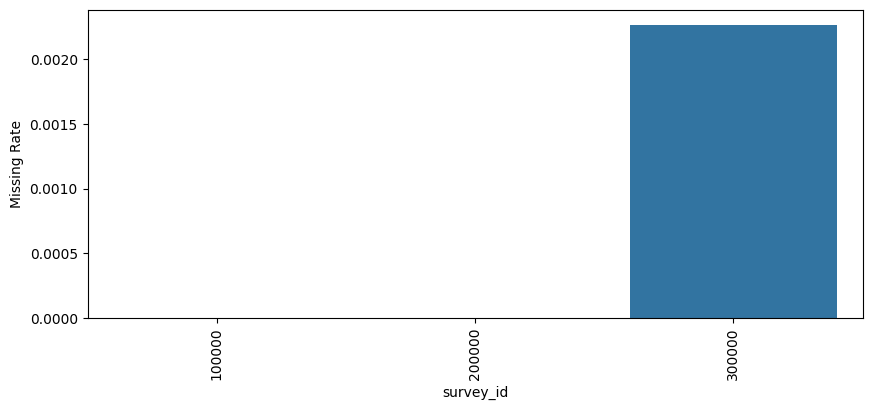

In [20]:
# survey_id × utl_exp_ppp17 결측률

miss_rate = (
    train
    .groupby("survey_id")["utl_exp_ppp17"]
    .apply(lambda x: x.isna().mean())
    .reset_index(name="missing_rate")
)

plt.figure(figsize=(10, 4))
sns.barplot(
    data=miss_rate.sort_values("missing_rate", ascending=False),
    x="survey_id",
    y="missing_rate"
)
plt.xticks(rotation=90)
plt.ylabel("Missing Rate")
plt.show()

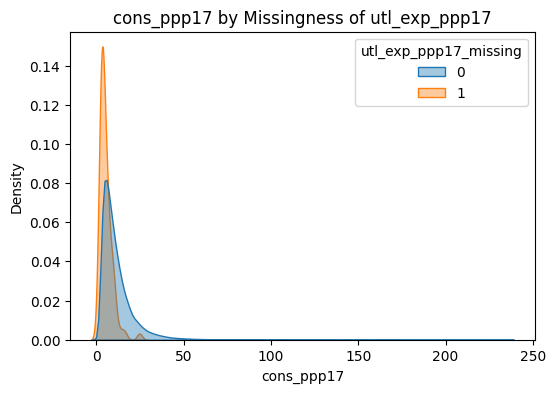

In [21]:
train["utl_exp_ppp17_missing"] = train["utl_exp_ppp17"].isna().astype(int)

plt.figure(figsize=(6, 4))
sns.kdeplot(
    data=train,
    x="cons_ppp17",
    hue="utl_exp_ppp17_missing",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.title("cons_ppp17 by Missingness of utl_exp_ppp17")
plt.show()

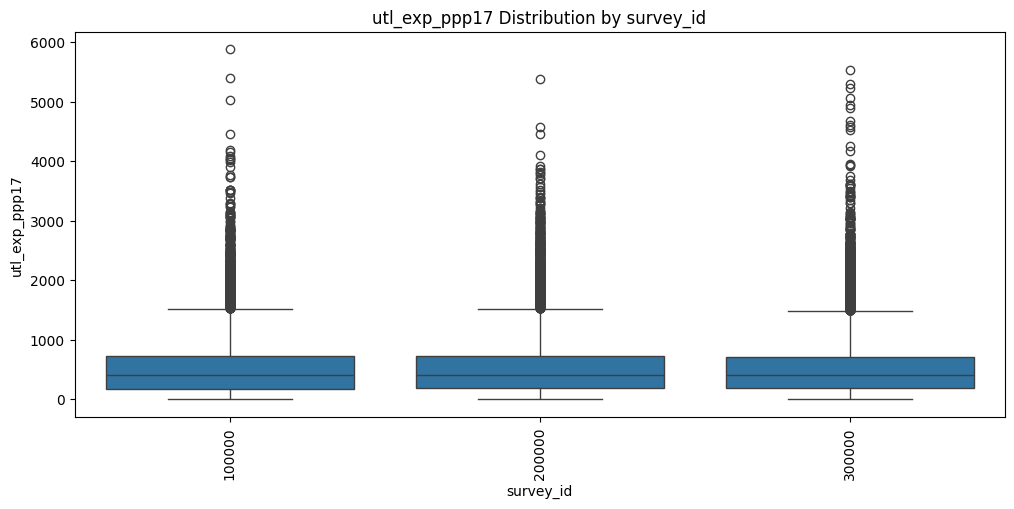

In [22]:
plt.figure(figsize=(12, 5))
sns.boxplot(
    data=train,
    x="survey_id",
    y="utl_exp_ppp17"
)
plt.xticks(rotation=90)
plt.title("utl_exp_ppp17 Distribution by survey_id")
plt.show()

- 1번 그림에서 보았을 때, survey_id 중 한 survey에서만 아주 소량(0.2%대) 결측
- 단순 비응답(missing at random에 가까움)
- survey_id별 분포 형태 거의 유사

> survey_id 별 중앙값으로 대치

**sector1d**

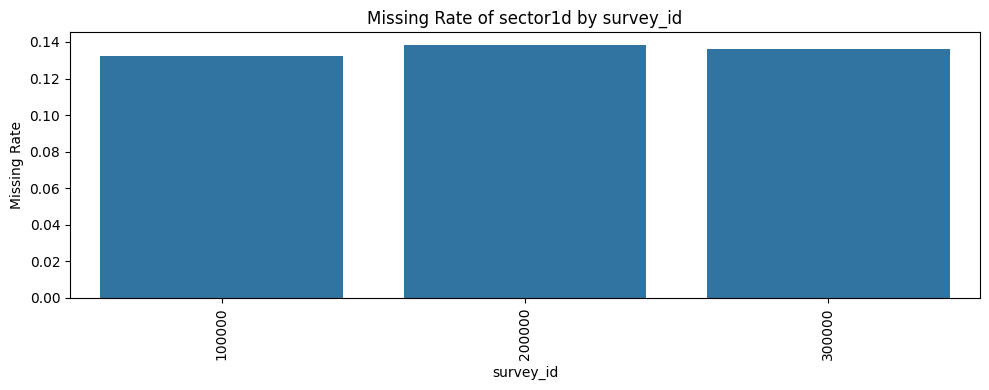

In [23]:
# survey별 결측률
miss_rate_sector = (
    train.groupby("survey_id")["sector1d"]
      .apply(lambda x: x.isna().mean())
      .reset_index(name="missing_rate")
      .sort_values("missing_rate", ascending=False)
)

plt.figure(figsize=(10, 4))
sns.barplot(data=miss_rate_sector, x="survey_id", y="missing_rate")
plt.xticks(rotation=90)
plt.ylabel("Missing Rate")
plt.title("Missing Rate of sector1d by survey_id")
plt.tight_layout()
plt.show()

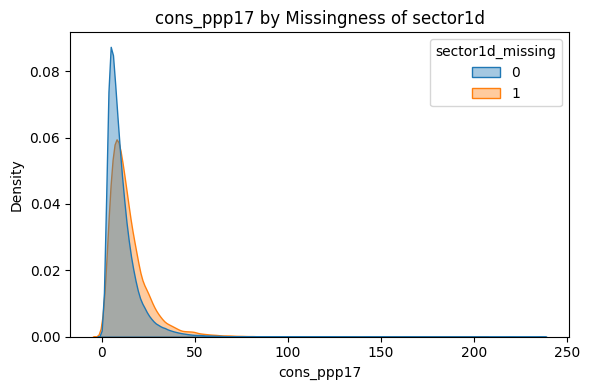

In [24]:
tmp = train[["sector1d", "cons_ppp17"]].copy()
tmp["sector1d_missing"] = tmp["sector1d"].isna().astype(int)

plt.figure(figsize=(6, 4))
sns.kdeplot(
    data=tmp,
    x="cons_ppp17",
    hue="sector1d_missing",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.title("cons_ppp17 by Missingness of sector1d")
plt.tight_layout()
plt.show()

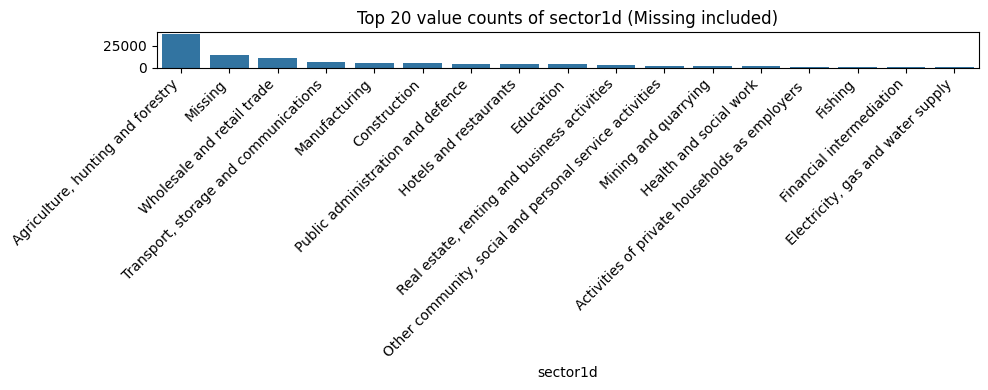

In [25]:
vc = train["sector1d"].astype("object").fillna("Missing").value_counts().head(20)

plt.figure(figsize=(10, 4))
sns.barplot(x=vc.index.astype(str), y=vc.values)
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 value counts of sector1d (Missing included)")
plt.tight_layout()
plt.show()


- 특정 survey에서만 튀는 패턴 없음 -> 구조적 결측 X
- 산업 정보 없음이 아니라분류되지 않는/복합/비표준 산업에 가까움
- missing이 큰 비중을 차지하고 있기에 의미있음

> Missing이라는 하나의 카테고리로 두고 결측 의미 보존 (indicator X)

**dweltyp**

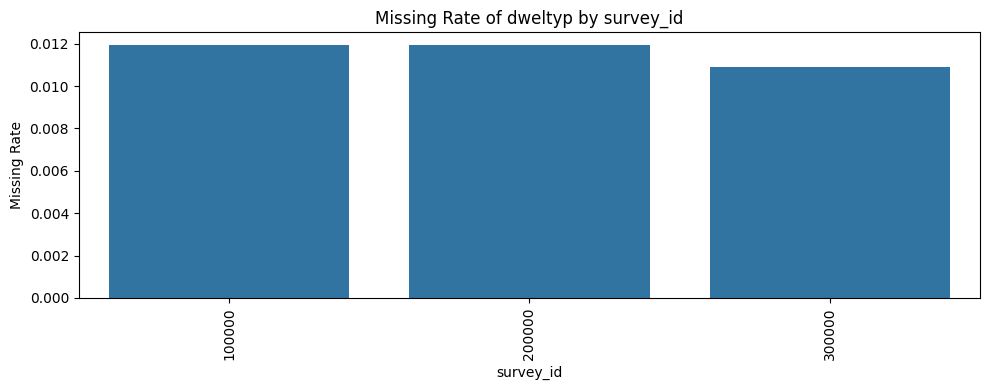

In [26]:
# survey별 결측률
miss_rate_dwel = (
    train.groupby("survey_id")["dweltyp"]
      .apply(lambda x: x.isna().mean())
      .reset_index(name="missing_rate")
      .sort_values("missing_rate", ascending=False)
)

plt.figure(figsize=(10, 4))
sns.barplot(data=miss_rate_dwel, x="survey_id", y="missing_rate")
plt.xticks(rotation=90)
plt.ylabel("Missing Rate")
plt.title("Missing Rate of dweltyp by survey_id")
plt.tight_layout()
plt.show()

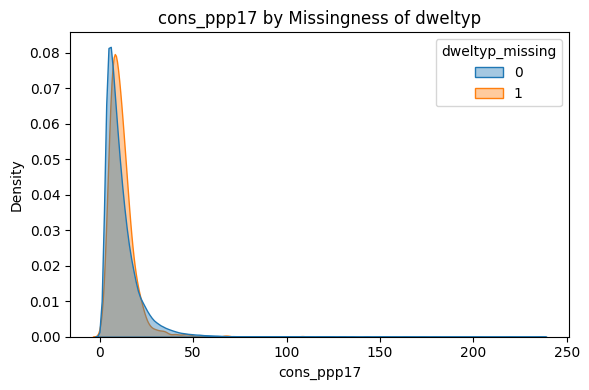

In [27]:
tmp = train[["dweltyp", "cons_ppp17"]].copy()
tmp["dweltyp_missing"] = tmp["dweltyp"].isna().astype(int)

plt.figure(figsize=(6, 4))
sns.kdeplot(
    data=tmp,
    x="cons_ppp17",
    hue="dweltyp_missing",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.title("cons_ppp17 by Missingness of dweltyp")
plt.tight_layout()
plt.show()


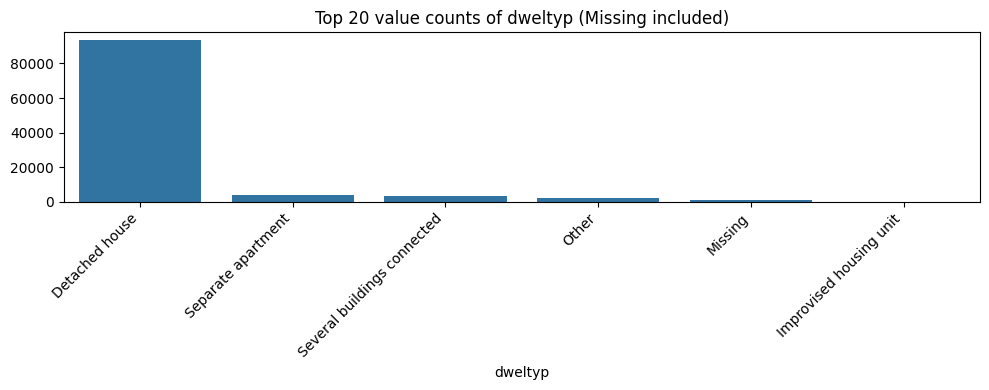

In [28]:
vc = train["dweltyp"].astype("object").fillna("Missing").value_counts().head(20)

plt.figure(figsize=(10, 4))
sns.barplot(x=vc.index.astype(str), y=vc.values)
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 value counts of dweltyp (Missing included)")
plt.tight_layout()
plt.show()


- survey 별 결측률 비슷 -> 구조적 결측 X
- 두번째 그림에서 보면, dweltyp 결측은 빈곤/부유 신호가 아니기에 결측 여부 자체를 모델이 배울 필요 없음 -> 결측 indicator 불필요

> Missing이라는 하나의 카테고리로 두고 결측 의미 보존 (indicator X)

**employed**

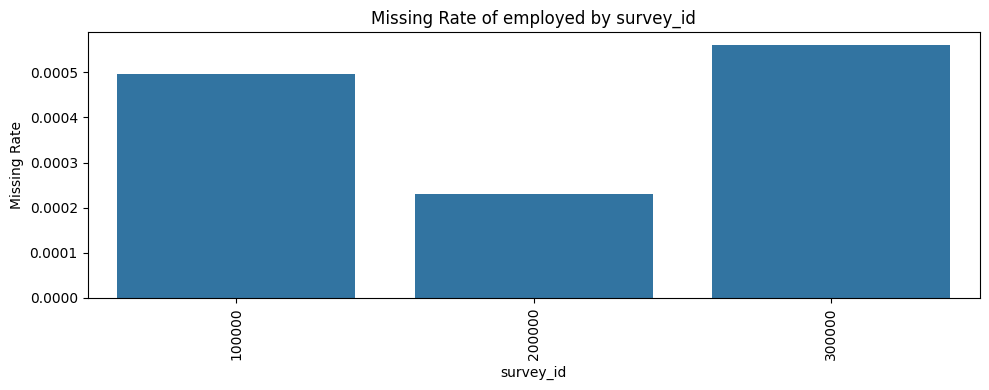

In [29]:
miss_rate_emp = (
    train.groupby("survey_id")["employed"]
      .apply(lambda x: x.isna().mean())
      .reset_index(name="missing_rate")
      .sort_values("missing_rate", ascending=False)
)

plt.figure(figsize=(10,4))
sns.barplot(data=miss_rate_emp, x="survey_id", y="missing_rate")
plt.xticks(rotation=90)
plt.ylabel("Missing Rate")
plt.title("Missing Rate of employed by survey_id")
plt.tight_layout()
plt.show()


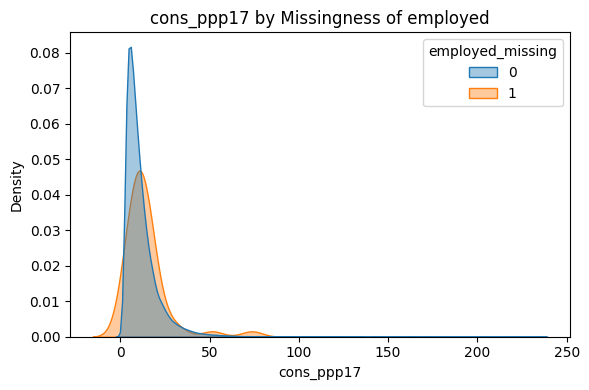

In [30]:
tmp = train[["employed", "cons_ppp17"]].copy()
tmp["employed_missing"] = tmp["employed"].isna().astype(int)

plt.figure(figsize=(6,4))
sns.kdeplot(
    data=tmp,
    x="cons_ppp17",
    hue="employed_missing",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.title("cons_ppp17 by Missingness of employed")
plt.tight_layout()
plt.show()


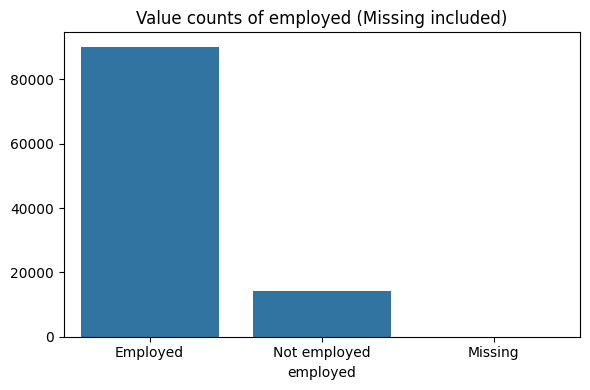

In [31]:
vc = (
    train["employed"]
    .astype("object")
    .fillna("Missing")
    .value_counts()
)

plt.figure(figsize=(6,4))
sns.barplot(x=vc.index.astype(str), y=vc.values)
plt.title("Value counts of employed (Missing included)")
plt.tight_layout()
plt.show()


- 모든 survey에서 결측률이 0.02~0.06% 수준
- 결측 자체는 의미 없음
- employed는 거의 완전 관측 변수이며 결측은 의미 없는 소수 오류로 봄

> Not employed로 처리

**educ_max**

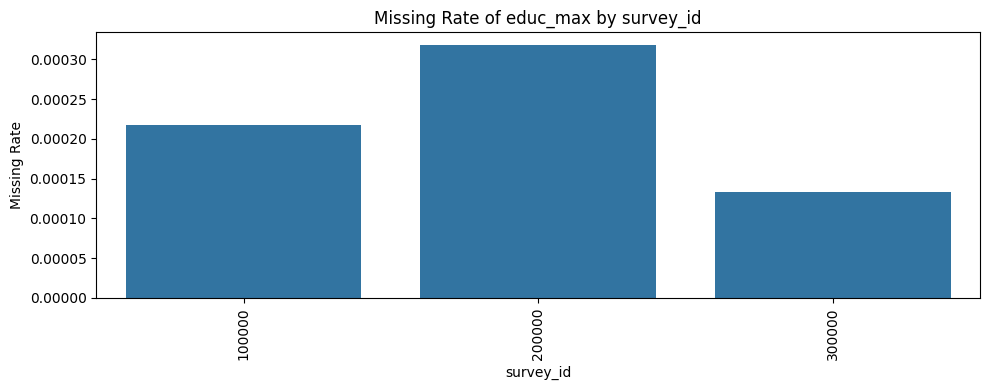

In [32]:
miss_rate_edu = (
    train.groupby("survey_id")["educ_max"]
      .apply(lambda x: x.isna().mean())
      .reset_index(name="missing_rate")
      .sort_values("missing_rate", ascending=False)
)

plt.figure(figsize=(10,4))
sns.barplot(data=miss_rate_edu, x="survey_id", y="missing_rate")
plt.xticks(rotation=90)
plt.ylabel("Missing Rate")
plt.title("Missing Rate of educ_max by survey_id")
plt.tight_layout()
plt.show()


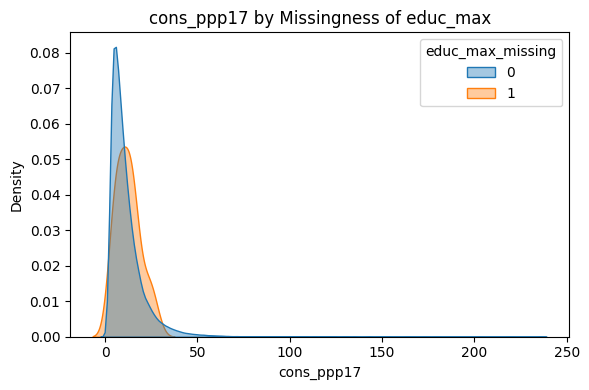

In [33]:
tmp = train[["educ_max", "cons_ppp17"]].copy()
tmp["educ_max_missing"] = tmp["educ_max"].isna().astype(int)

plt.figure(figsize=(6,4))
sns.kdeplot(
    data=tmp,
    x="cons_ppp17",
    hue="educ_max_missing",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.title("cons_ppp17 by Missingness of educ_max")
plt.tight_layout()
plt.show()


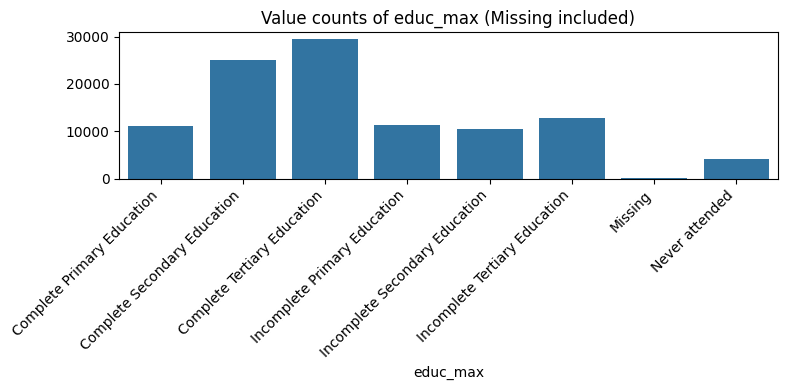

In [34]:
vc = (
    train["educ_max"]
    .astype("object")
    .fillna("Missing")
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(8,4))
sns.barplot(x=vc.index.astype(str), y=vc.values)
plt.xticks(rotation=45, ha="right")
plt.title("Value counts of educ_max (Missing included)")
plt.tight_layout()
plt.show()


- survey 간 거의 동일 → 극히 소수의 응답 누락
- missing 분포 거의 동일 → 단순 비응답
- Never attended라는 최저 학력 카테고리가 이미 존재
- 즉, 결측은 학력 없음이 아니라 학력 정보 미응답으로 해석하는 것이 타당

> missing 카테고리 유지

**consumed**

In [35]:
consumed_cols = [c for c in train.columns if c.startswith("consumed")]

miss_rate_consumed = (
    train[consumed_cols]
    .isna()
    .mean()
    .sort_values(ascending=False)
)

display(miss_rate_consumed)


,0
consumed5000,0.000633
consumed4800,0.000537
consumed4600,0.000537
consumed4900,0.000537
consumed4500,0.000518
consumed4300,0.000499
consumed4400,0.000499
consumed4700,0.000499
consumed4200,0.000422
consumed3900,0.000384


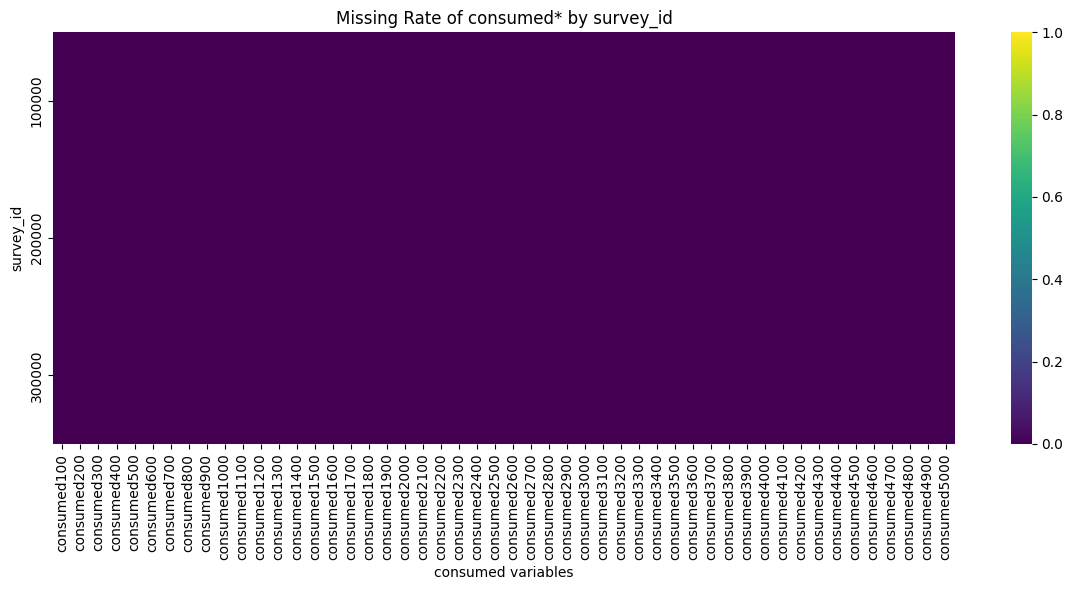

In [36]:
miss_by_survey = (
    train.groupby("survey_id")[consumed_cols]
      .apply(lambda g: g.isna().mean())
)

plt.figure(figsize=(12, 6))
sns.heatmap(miss_by_survey, cmap="viridis", vmin=0, vmax=1)
plt.title("Missing Rate of consumed* by survey_id")
plt.xlabel("consumed variables")
plt.ylabel("survey_id")
plt.tight_layout()
plt.show()


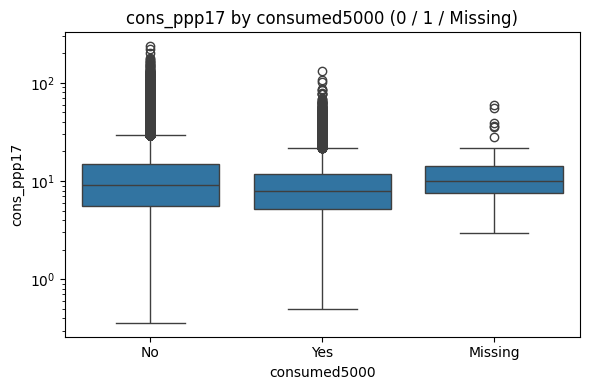

In [37]:
col = "consumed5000"

tmp = train[[col, "cons_ppp17"]].copy()
tmp[col] = tmp[col].astype("object")

plt.figure(figsize=(6,4))
sns.boxplot(
    data=tmp,
    x=tmp[col].fillna("Missing"),
    y="cons_ppp17"
)
plt.yscale("log")
plt.title(f"cons_ppp17 by {col} (0 / 1 / Missing)")
plt.tight_layout()
plt.show()


- 결측률이 아주 낮음 → 입력 누락 가능성 ↑
- 모든 survey에 고르게 NaN → 비응답 or 0과 같은 의미 가능성
- 해당 소비를 했는지 여부에 관한 것이기에 소비를 하지 않았다고 보는 것이 가장 타당

> 결측 0으로 처리

**share_secondary**

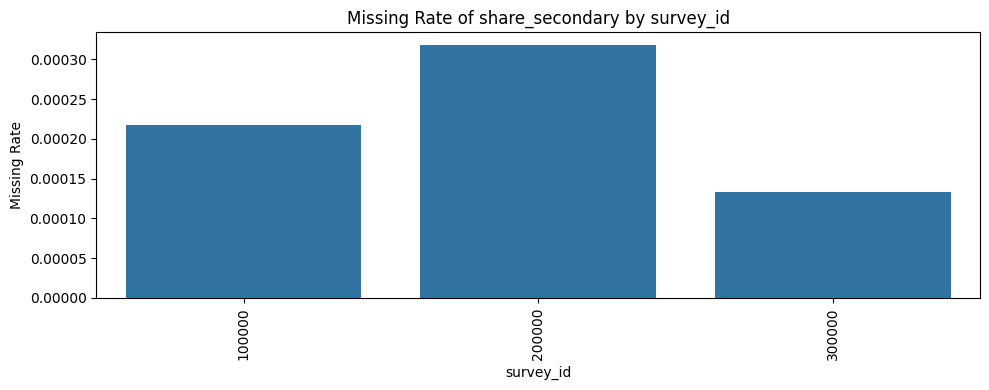

In [38]:
miss_rate_share = (
    train.groupby("survey_id")["share_secondary"]
      .apply(lambda x: x.isna().mean())
      .reset_index(name="missing_rate")
      .sort_values("missing_rate", ascending=False)
)

plt.figure(figsize=(10,4))
sns.barplot(data=miss_rate_share, x="survey_id", y="missing_rate")
plt.xticks(rotation=90)
plt.ylabel("Missing Rate")
plt.title("Missing Rate of share_secondary by survey_id")
plt.tight_layout()
plt.show()


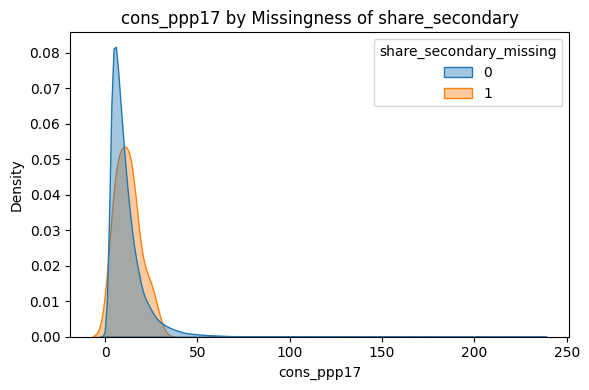

In [39]:
tmp = train[["share_secondary", "cons_ppp17"]].copy()
tmp["share_secondary_missing"] = tmp["share_secondary"].isna().astype(int)

plt.figure(figsize=(6,4))
sns.kdeplot(
    data=tmp,
    x="cons_ppp17",
    hue="share_secondary_missing",
    common_norm=False,
    fill=True,
    alpha=0.4
)
plt.title("cons_ppp17 by Missingness of share_secondary")
plt.tight_layout()
plt.show()


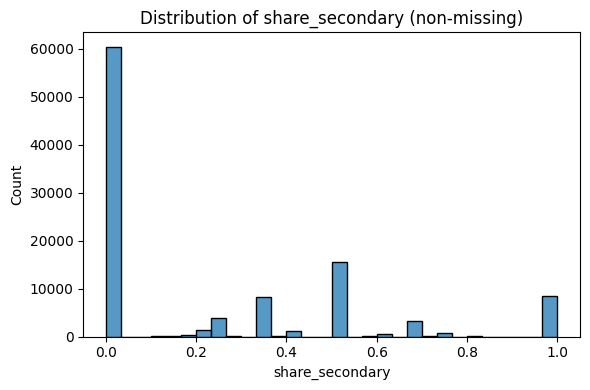

In [40]:
plt.figure(figsize=(6,4))
sns.histplot(train["share_secondary"], bins=30)
plt.title("Distribution of share_secondary (non-missing)")
plt.tight_layout()
plt.show()


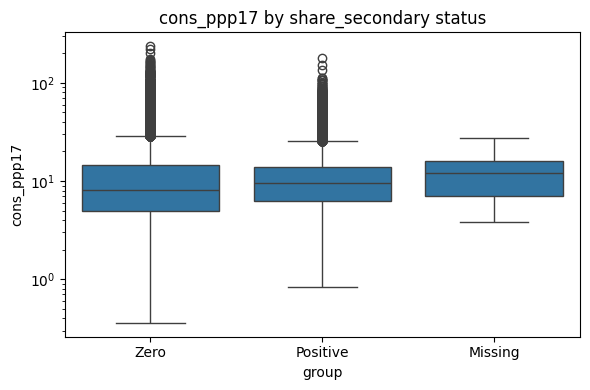

In [41]:
tmp2 = train[["share_secondary", "cons_ppp17"]].copy()
tmp2["group"] = np.where(
    tmp2["share_secondary"].isna(), "Missing",
    np.where(tmp2["share_secondary"] == 0, "Zero", "Positive")
)

plt.figure(figsize=(6,4))
sns.boxplot(data=tmp2, x="group", y="cons_ppp17")
plt.yscale("log")
plt.title("cons_ppp17 by share_secondary status")
plt.tight_layout()
plt.show()


- survey 모두 비슷 → 개인 단위 계산 불가/비응답
-  missing 분포 거의 동일 → 결측 자체 정보 없음
- 낮은 소비 구간에서 missing이 더 취약 X → 결측 = 빈곤 신호 X
- 0 값이 압도적으로 많음
- 4번째 그래프로 보아, Missing 그룹이 Zero 그룹보다 소비 수준이 높음 → 0으로 채우면 X

> 전체 중앙값으로 대치

### 결측 처리 방법 정리



| 변수                | 성격  | 코멘트              |
| ----------------- | --- | ---------------- |
| `sector1d`        | 범주형 | Missing이라는 하나의 카테고리로 유지 |
| `dweltyp`         | 범주형 | Missing이라는 하나의 카테고리로 유지 |
| `employed`        | 범주형 | Not employed로 처리 |
| `educ_max`        | 범주형 | Missing이라는 하나의 카테고리로 유지 |
| `consumed`        | 더미형 | 0으로 처리 |
| `share_secondary` | 수치형 | train 기준 전체 중앙값으로 대치 |
| `utl_exp_ppp17`   | 수치형 | survey_id 별 중앙값으로 대치 |

## 결측 채우기

In [42]:
# 가공본 만들기 (원본 보존)
X_tr   = X_tr_raw.copy()
X_val  = X_val_raw.copy()
X_test = X_test_raw.copy()

In [43]:
col = "sector1d"

X_tr[col]   = X_tr[col].astype("object").fillna("Missing")
X_val[col]  = X_val[col].astype("object").fillna("Missing")
X_test[col] = X_test[col].astype("object").fillna("Missing")

print(col, X_tr[col].isna().sum(), X_val[col].isna().sum(), X_test[col].isna().sum())

sector1d 0 0 0


In [44]:
col = "dweltyp"

X_tr[col]   = X_tr[col].astype("object").fillna("Missing")
X_val[col]  = X_val[col].astype("object").fillna("Missing")
X_test[col] = X_test[col].astype("object").fillna("Missing")

print(col, X_tr[col].isna().sum(), X_val[col].isna().sum(), X_test[col].isna().sum())

dweltyp 0 0 0


In [45]:
col = "employed"

X_tr[col]   = X_tr[col].fillna("Not employed")
X_val[col]  = X_val[col].fillna("Not employed")
X_test[col] = X_test[col].fillna("Not employed")

print(col, X_tr[col].isna().sum(), X_val[col].isna().sum(), X_test[col].isna().sum())

employed 0 0 0


In [46]:
col = "educ_max"

X_tr[col]   = X_tr[col].astype("object").fillna("Missing")
X_val[col]  = X_val[col].astype("object").fillna("Missing")
X_test[col] = X_test[col].astype("object").fillna("Missing")

print(col, X_tr[col].isna().sum(), X_val[col].isna().sum(), X_test[col].isna().sum())

educ_max 0 0 0


In [47]:
consumed_cols = [c for c in X_tr.columns if c.startswith("consumed")]

map_dict = {"Yes": 1, "No": 0}

for df_ in [X_tr, X_val, X_test]:
    df_[consumed_cols] = (df_[consumed_cols].replace(map_dict).fillna(0))

# dtype 정리 (0/1 더미로 유지)
for df_ in [X_tr, X_val, X_test]:
    df_[consumed_cols] = df_[consumed_cols].astype("int64")

print("consumed*: missing counts",
      X_tr[consumed_cols].isna().sum().sum(),
      X_val[consumed_cols].isna().sum().sum(),
      X_test[consumed_cols].isna().sum().sum())

/tmp/ipython-input-930073891.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_[consumed_cols] = (df_[consumed_cols].replace(map_dict).fillna(0))
/tmp/ipython-input-930073891.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_[consumed_cols] = (df_[consumed_cols].replace(map_dict).fillna(0))
/tmp/ipython-input-930073891.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to th

consumed*: missing counts 0 0 0


In [48]:
col = "share_secondary"

share_median = X_tr[col].median()  # fit on train only

X_tr[col]   = X_tr[col].fillna(share_median)
X_val[col]  = X_val[col].fillna(share_median)
X_test[col] = X_test[col].fillna(share_median)

print(col, "median(train)=", share_median)
print(col, X_tr[col].isna().sum(), X_val[col].isna().sum(), X_test[col].isna().sum())

share_secondary median(train)= 0.0
share_secondary 0 0 0


In [49]:
col = "utl_exp_ppp17"

# fit: train_df의 survey_id별 중앙값 (X_tr의 col 기준)
utl_median_by_survey = (
    pd.concat([train_df["survey_id"], X_tr[col]], axis=1)
      .groupby("survey_id")[col]
      .median()
)

global_median = X_tr[col].median()

# transform: train
X_tr[col] = X_tr[col].fillna(train_df["survey_id"].map(utl_median_by_survey)).fillna(global_median)

# transform: val (train에 없는 survey_id면 global median)
X_val[col] = X_val[col].fillna(val_df["survey_id"].map(utl_median_by_survey)).fillna(global_median)

# transform: test
X_test[col] = X_test[col].fillna(test["survey_id"].map(utl_median_by_survey)).fillna(global_median)

print(col, "global_median(train)=", global_median)
print(col, X_tr[col].isna().sum(), X_val[col].isna().sum(), X_test[col].isna().sum())

utl_exp_ppp17 global_median(train)= 405.79352
utl_exp_ppp17 0 0 0


In [50]:
print("Top missing in X_tr:\n", X_tr.isna().sum().sort_values(ascending=False).head(20))
print("Top missing in X_val:\n", X_val.isna().sum().sort_values(ascending=False).head(20))
print("Top missing in X_test:\n", X_test.isna().sum().sort_values(ascending=False).head(20))

Top missing in X_tr:
 com                  0
weight               0
strata               0
utl_exp_ppp17        0
male                 0
hsize                0
num_children5        0
num_children10       0
num_children18       0
age                  0
owner                0
water                0
toilet               0
sewer                0
elect                0
water_source         0
sanitation_source    0
dweltyp              0
num_adult_female     0
num_adult_male       0
dtype: int64
Top missing in X_val:
 com                  0
weight               0
strata               0
utl_exp_ppp17        0
male                 0
hsize                0
num_children5        0
num_children10       0
num_children18       0
age                  0
owner                0
water                0
toilet               0
sewer                0
elect                0
water_source         0
sanitation_source    0
dweltyp              0
num_adult_female     0
num_adult_male       0
dtype: int64
Top missi

**범주형 확인**

In [51]:
cat_cols_tr = [c for c in X_tr.columns if X_tr[c].dtype == "object"]
cat_cols_tr

['male',
 'owner',
 'water',
 'toilet',
 'sewer',
 'elect',
 'water_source',
 'sanitation_source',
 'dweltyp',
 'employed',
 'educ_max',
 'any_nonagric',
 'sector1d',
 'urban']

In [52]:
cat_cols_val = [c for c in X_val.columns if X_val[c].dtype == "object"]
cat_cols_val

['male',
 'owner',
 'water',
 'toilet',
 'sewer',
 'elect',
 'water_source',
 'sanitation_source',
 'dweltyp',
 'employed',
 'educ_max',
 'any_nonagric',
 'sector1d',
 'urban']

In [53]:
cat_cols_test = [c for c in X_test.columns if X_test[c].dtype == "object"]
cat_cols_test

['male',
 'owner',
 'water',
 'toilet',
 'sewer',
 'elect',
 'water_source',
 'sanitation_source',
 'dweltyp',
 'employed',
 'educ_max',
 'any_nonagric',
 'sector1d',
 'urban']

In [54]:
y_tr

,cons_ppp17
32188,18.440580
32189,3.154654
32190,7.586660
32191,14.376097
32192,10.031622
...,...
104229,2.830888
104230,3.144309
104231,3.319158
104232,6.088739


In [55]:
for df in [X_tr, X_val, X_test]:
    df["log_weight"] = np.log1p(df["weight"])
    df.drop(columns=["weight"], inplace=True)

# 전처리 완료된 데이터셋 - ver1

In [56]:
# X_tr.to_csv("X_tr.csv", index=False)
# X_val.to_csv("X_val.csv", index=False)
# X_test.to_csv("X_test.csv", index=False)
# y_tr.to_csv("y_tr.csv", index=False)
# y_val.to_csv("y_val.csv", index=False)

In [57]:
# train.to_csv("train.csv", index=False)
# test_id.to_csv("test_id.csv", index=False)

# < 추가 전처리 >

## 1. 범주형 그대로, 수치형 indicator 추가

In [58]:
# ===== 결측 indicator 추가 (수치형 변수만) =====
from pandas.api.types import is_numeric_dtype

# 1) train 기준으로, 결측이 있는 수치형 변수만 골라오기
num_na_cols = [
    col for col in X_tr_raw.columns
    if is_numeric_dtype(X_tr_raw[col]) and X_tr_raw[col].isna().any()
]

print("결측 있는 수치형 변수들:")
print(num_na_cols)

# 2) 원본(raw) 기준으로 결측 여부를 0/1로 만들어서
#    가공본(X_tr, X_val, X_test)에 indicator 컬럼으로 붙이기
for col in num_na_cols:
    flag_col = col + "_isna"   # 예: 'share_secondary_isna'

    X_tr[flag_col]   = X_tr_raw[col].isna().astype("int8")
    X_val[flag_col]  = X_val_raw[col].isna().astype("int8")
    X_test[flag_col] = X_test_raw[col].isna().astype("int8")

print("indicator 생성 완료! (추가된 컬럼 수:", len(num_na_cols), ")")

결측 있는 수치형 변수들:
['utl_exp_ppp17', 'share_secondary']
indicator 생성 완료! (추가된 컬럼 수: 2 )


## 2. 파생 변수 추가

> “총지출 1000”보다 → “4인 가구에서 1000인지, 1인 가구에서 1000인지”가 핵심

- A. 1인당 지표

total_consumption / hh_size

income / hh_size

land_area / hh_size

rooms / hh_size

- B. 구성비

food_exp / total_exp

agri_income / total_income

nonfood_exp / total_exp

- C. 부양/노동 구조

num_children / hh_size

num_workers / hh_size


In [59]:
def safe_divide(a, b):
    return a / (b + 1e-6)

In [60]:
# 1인당(per capita) 파생변수
per_capita_pairs = {
    "consumption": "hh_size",
    "income": "hh_size",
    "total_exp": "hh_size",
    "land_area": "hh_size",
    "rooms": "hh_size"
}

for num, den in per_capita_pairs.items():
    if num in X_tr.columns and den in X_tr.columns:
        new_col = f"{num}_per_{den}"
        X_tr[new_col]   = safe_divide(X_tr[num], X_tr[den])
        X_val[new_col]  = safe_divide(X_val[num], X_val[den])
        X_test[new_col] = safe_divide(X_test[num], X_test[den])

In [61]:
# 비율(ratio) 파생변수
ratio_pairs = {
    "food_exp": "total_exp",
    "nonfood_exp": "total_exp",
    "agri_income": "total_income",
    "wage_income": "total_income",
    "secondary_acre": "land_area"
}

for num, den in ratio_pairs.items():
    if num in X_tr.columns and den in X_tr.columns:
        new_col = f"{num}_ratio_{den}"
        X_tr[new_col]   = safe_divide(X_tr[num], X_tr[den])
        X_val[new_col]  = safe_divide(X_val[num], X_val[den])
        X_test[new_col] = safe_divide(X_test[num], X_test[den])

## 3. Survey 기준 상대화 변수

In [62]:
group_col = "survey_id"

rel_targets = ["consumption", "income", "total_exp"]

for col in rel_targets:
    if col in X_tr.columns and group_col in X_tr.columns:
        med = X_tr.groupby(group_col)[col].median()

        X_tr[f"{col}_rel_survey"] = X_tr[col] / X_tr[group_col].map(med)
        X_val[f"{col}_rel_survey"] = X_val[col] / X_val[group_col].map(med)
        X_test[f"{col}_rel_survey"] = X_test[col] / X_test[group_col].map(med)

## 4. 극단치 완화용 파생

In [63]:
log_targets = ["consumption", "income", "total_exp", "land_area"]

for col in log_targets:
    if col in X_tr.columns:
        X_tr[f"log_{col}"]   = np.log1p(X_tr[col])
        X_val[f"log_{col}"]  = np.log1p(X_val[col])
        X_test[f"log_{col}"] = np.log1p(X_test[col])

# 전처리 완료된 데이터셋 - ver2

In [64]:
X_tr.to_csv("X_tr_preprocessed.csv", index=False)
X_val.to_csv("X_val_preprocessed.csv", index=False)
X_test.to_csv("X_test_preprocessed.csv", index=False)